# Intro

In this project different methods and algorithms of image quantization are shown

# Algorithms

In [1]:
!pip install opencv-python

In [2]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

# img_source = 'images/hills.jpeg'
img_source = 'images/example.png'

**View images:**

Width: 614 pixels
Height: 850 pixels
Number of channels: 3
Image size: 1565700 bytes
Image data type: uint8


(-0.5, 613.5, 849.5, -0.5)

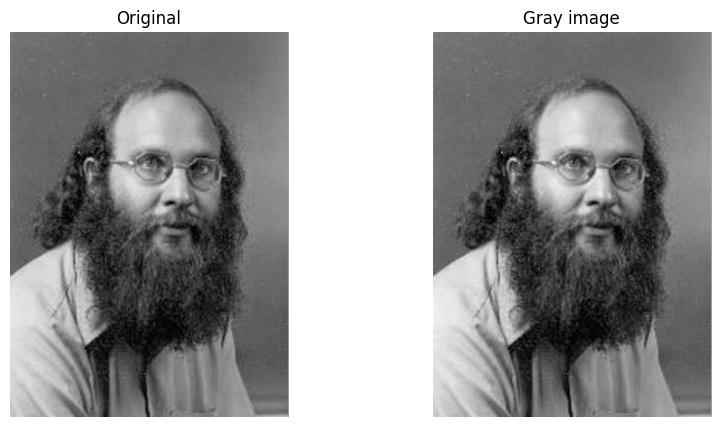

In [3]:
img = cv2.imread(img_source)
# plt.imshow(img)

gray_image = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
# plt.imshow(gray_image, cmap='gray')

height, width, channels = img.shape
print(f"Width: {width} pixels")
print(f"Height: {height} pixels")
print(f"Number of channels: {channels}")
print(f"Image size: {img.size} bytes")
print(f"Image data type: {img.dtype}")

plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
plt.imshow(img)
plt.title('Original')
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(gray_image, cmap='gray')
plt.title('Gray image')
plt.axis('off')


## Uniform gray image quantization
level = 20

True

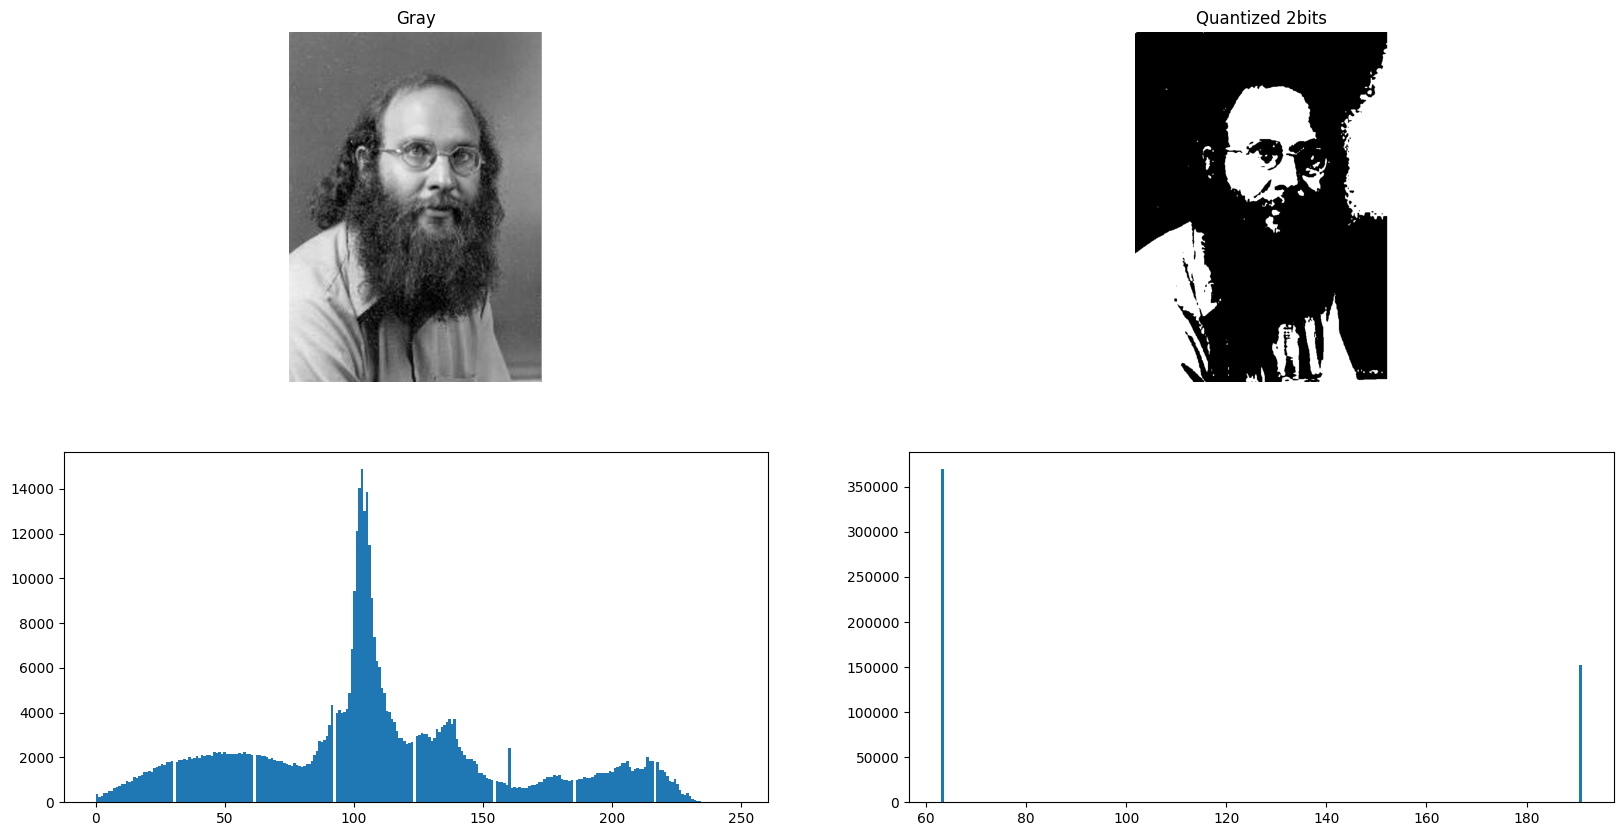

In [4]:
level = 2

quantized_image = np.array(gray_image).copy()
delta = 255/level
for i in range(gray_image.shape[0]):
    for j in range(gray_image.shape[1]):
        quantized_image[i][j] = int(np.floor(gray_image[i][j]/delta)*delta+delta/2)

plt.figure(figsize=(20,10))


plt.subplot(2,2,1)
plt.imshow(gray_image, cmap='gray')
plt.title('Gray')
plt.axis('off')

plt.subplot(2,2,2)
plt.imshow(quantized_image, cmap='gray')
plt.title(f'Quantized {level}bits')
plt.axis('off')


plt.subplot(2,2,3)
_=plt.hist(gray_image.ravel(), bins=256)

plt.subplot(2,2,4)
_=plt.hist(quantized_image.ravel(), bins=256)

cv2.imwrite('images/gray_hills.jpeg',gray_image)
cv2.imwrite('images/quantized_gray_hills.jpeg',quantized_image)

## Median cut quantization

Median cut uses median color to split the range of colors into two and have average by them. Depth is used to identify amount of colors are wanted in result.

>Algorithm:
>1. Flatten image into one single array
>2. Find color with highest range
>3. Sort by this color
>4. Take median
>5. Split into buckets by median and repeat until desired depth
>6. For final 0-depth buckets define average color and set for image


https://web.archive.org/web/20190202154003/http://www.leptonica.com/papers/mediancut.pdf \
https://www.researchgate.net/publication/26339916_Optimal_image_quantization_perception_and_the_median_cut_algorithm

In [5]:
import matplotlib.pyplot as plt
import numpy as np


def median_cut_quantize(img, img_arr): # set average color in bucket
    r_average = np.mean(img_arr[:,0])
    g_average = np.mean(img_arr[:,1])
    b_average = np.mean(img_arr[:,2])
    for data in img_arr:
        img[data[3]][data[4]] = [r_average, g_average, b_average]

# finding max-range color, sort by it to take median -> split into buckets by this median. Resulting with 2^depth buckets (colors)
def split_into_buckets(img, img_arr, depth): 
    if len(img_arr) == 0:
        return 
        
    if depth == 0:
        median_cut_quantize(img, img_arr)
        return
    
    r_range = np.max(img_arr[:,0]) - np.min(img_arr[:,0])
    g_range = np.max(img_arr[:,1]) - np.min(img_arr[:,1])
    b_range = np.max(img_arr[:,2]) - np.min(img_arr[:,2])
    max_range_space = (0 if r_range*2>g_range+b_range else 1 if g_range*2>b_range+r_range else 2)

    # sort by color
    img_arr = img_arr[img_arr[:,max_range_space].argsort()]
    median_index = int((len(img_arr)+1)/2) # bucket split index
    # print("median_index:", median_index)

    
    # split by median
    split_into_buckets(img, img_arr[0:median_index], depth-1)
    split_into_buckets(img, img_arr[median_index:], depth-1)

Initial number of colors: 242
Resulting number of colors: 2


Text(0.5, 1.0, 'Histogram 2bits')

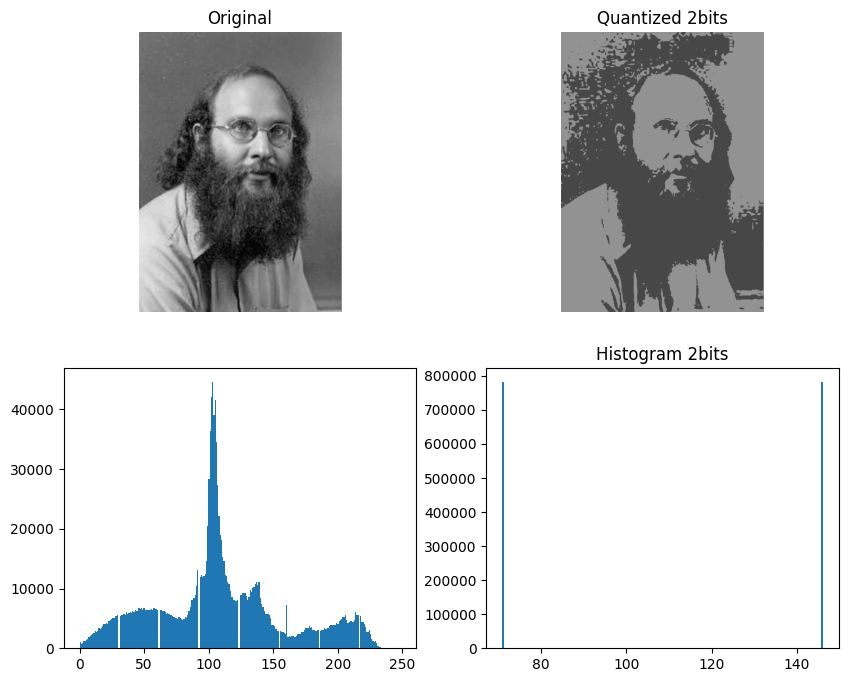

In [6]:
image = cv2.imread(img_source)
bits = 1

# list of pixels with their positions in image
flattened_img_array = []
for row_index, rows in enumerate(image):
    for color_index, color in enumerate(rows):
        flattened_img_array.append([color[0],color[1],color[2], row_index, color_index]) 
# print('len',len(flattened_img_array))


plt.figure(figsize=(10,8))

plt.subplot(2,2,1)
plt.imshow(image, cmap='gray')
plt.title('Original')
plt.axis('off')

plt.subplot(2,2,3)
_=plt.hist(image.ravel(), bins=256)
print('Initial number of colors:', np.unique(image.reshape(-1, image.shape[-1]), axis=0).shape[0])

flattened_img_array = np.array(flattened_img_array)
split_into_buckets(image, flattened_img_array, bits)

plt.subplot(2,2,2)
plt.imshow(image,cmap='gray')
plt.title(f'Quantized {2**bits}bits')
plt.axis('off')

# print(np.unique(image.reshape(-1, image.shape[-1]), axis=0))
print('Resulting number of colors:', np.unique(image.reshape(-1, image.shape[-1]), axis=0).shape[0])

plt.subplot(2,2,4)
_=plt.hist(image.ravel(), bins=256)
plt.title(f'Histogram {2**bits}bits')

## Random dithering 1 bit

True

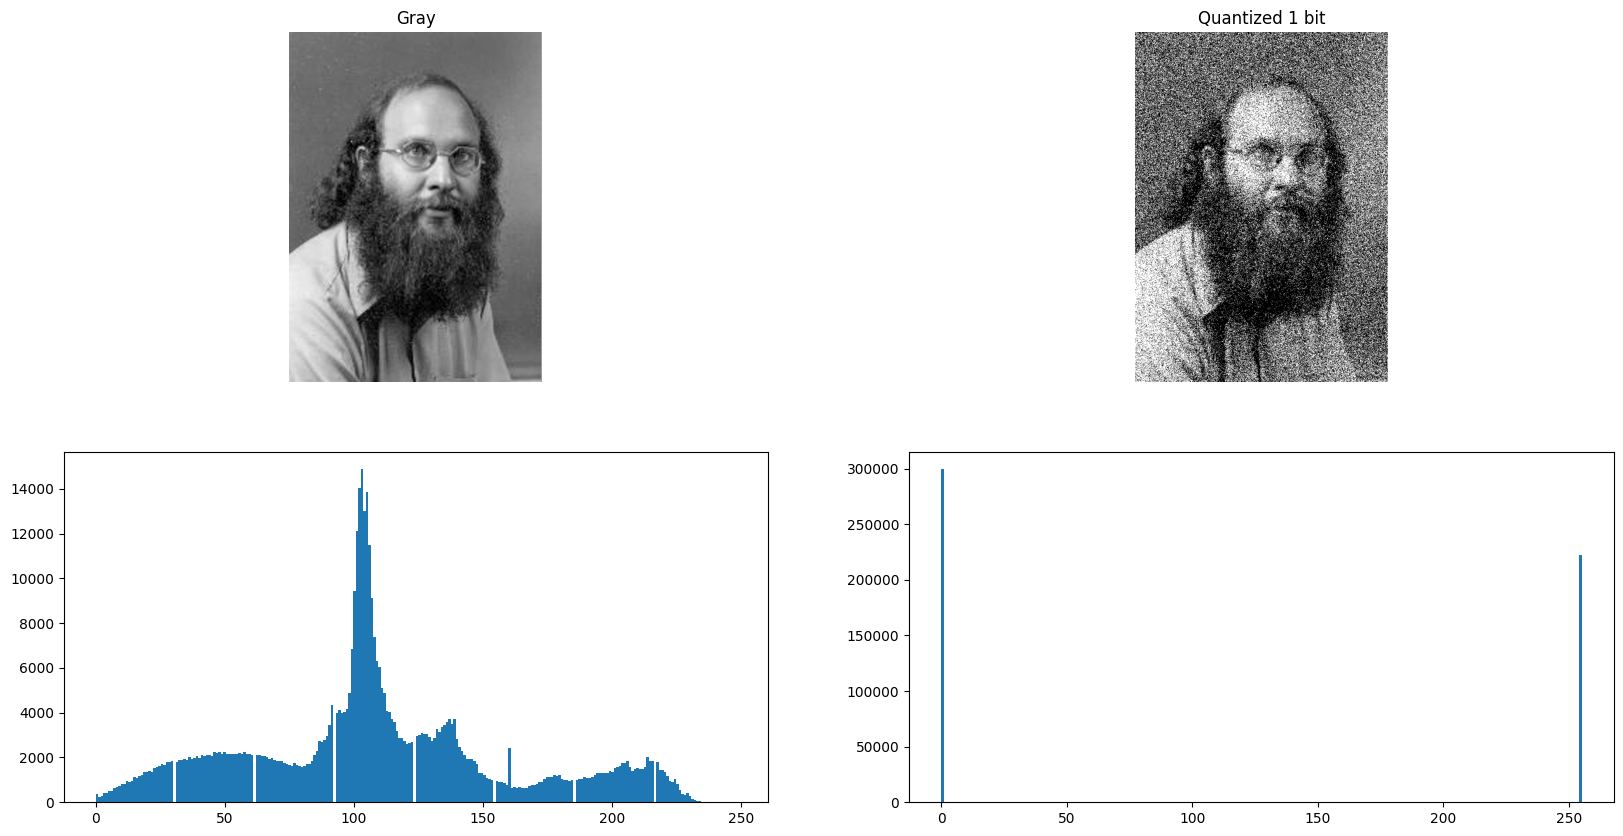

In [7]:
# level = 2
treshold = 127

image = cv2.imread(img_source)
gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

quantized_image = np.array(gray_image).copy()
# delta = 255/level
for i in range(gray_image.shape[0]):
    for j in range(gray_image.shape[1]):
        # quantized_image[i][j] = int(np.floor(gray_image[i][j]/delta)*delta+delta/2 + np.random.randint(-127,127))
        # quantized_image[i][j] = 255 if gray_image[i][j]>treshold else 0
        quantized_image[i][j] = 255 if gray_image[i][j]+np.random.randint(-127,127)>treshold else 0

plt.figure(figsize=(20,10))


plt.subplot(2,2,1)
plt.imshow(gray_image, cmap='gray')
plt.title('Gray')
plt.axis('off')

plt.subplot(2,2,2)
plt.imshow(quantized_image, cmap='gray')
plt.title(f'Quantized 1 bit')
plt.axis('off')


plt.subplot(2,2,3)
_=plt.hist(gray_image.ravel(), bins=256)

plt.subplot(2,2,4)
_=plt.hist(quantized_image.ravel(), bins=256)

cv2.imwrite('images/gray_hills.jpeg',gray_image)
cv2.imwrite('images/quantized_gray_hills.jpeg',quantized_image)

## Ordered dithering uding Bayer's matrices

C:\Users\glebo\AppData\Local\Temp\ipykernel_22452\1912676909.py:11: DeprecationWarning: NumPy will stop allowing conversion of out-of-bound Python integers to integer arrays.  The conversion of -63 to uint8 will fail in the future.
For the old behavior, usually:
    np.array(value).astype(dtype)
will give the desired result (the cast overflows).
  quantized_image[i][j] = int(np.floor((gray_image[i][j]+ np.random.randint(-127,127))/delta)*delta+delta/2)
C:\Users\glebo\AppData\Local\Temp\ipykernel_22452\1912676909.py:11: DeprecationWarning: NumPy will stop allowing conversion of out-of-bound Python integers to integer arrays.  The conversion of 318 to uint8 will fail in the future.
For the old behavior, usually:
    np.array(value).astype(dtype)
will give the desired result (the cast overflows).
  quantized_image[i][j] = int(np.floor((gray_image[i][j]+ np.random.randint(-127,127))/delta)*delta+delta/2)


True

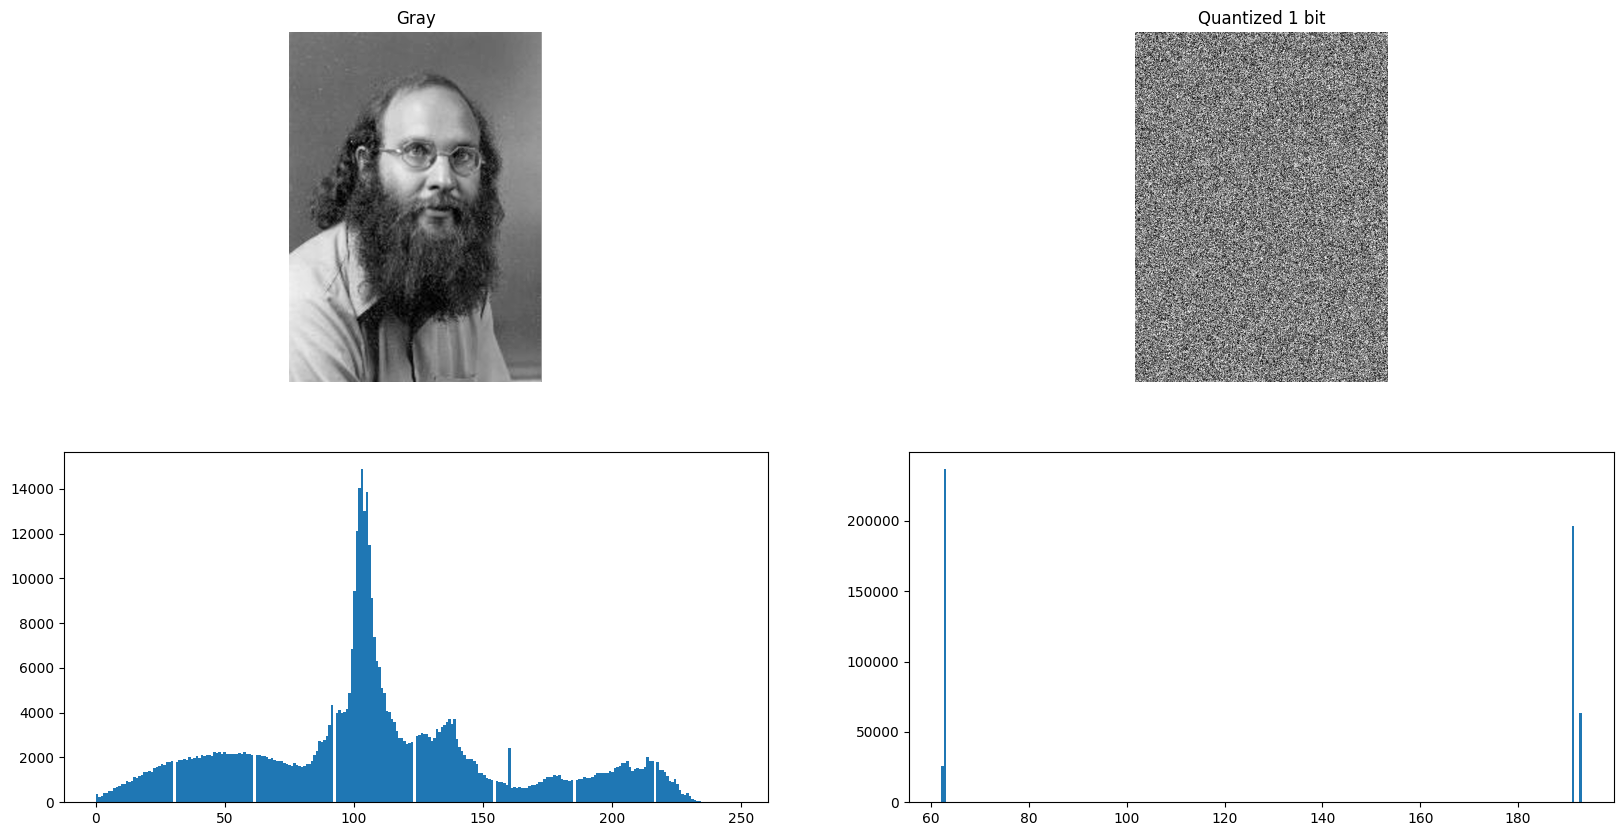

In [8]:
level = 2
# treshold = 127

image = cv2.imread(img_source)
gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

quantized_image = np.array(gray_image).copy()
delta = 255/level
for i in range(gray_image.shape[0]):
    for j in range(gray_image.shape[1]):
        quantized_image[i][j] = int(np.floor((gray_image[i][j]+ np.random.randint(-127,127))/delta)*delta+delta/2)

plt.figure(figsize=(20,10))


plt.subplot(2,2,1)
plt.imshow(gray_image, cmap='gray')
plt.title('Gray')
plt.axis('off')

plt.subplot(2,2,2)
plt.imshow(quantized_image, cmap='gray')
plt.title(f'Quantized 1 bit')
plt.axis('off')


plt.subplot(2,2,3)
_=plt.hist(gray_image.ravel(), bins=256)

plt.subplot(2,2,4)
_=plt.hist(quantized_image.ravel(), bins=256)

cv2.imwrite('images/gray_hills.jpeg',gray_image)
cv2.imwrite('images/quantized_gray_hills.jpeg',quantized_image)

# Sources
> https://www.cs.princeton.edu/courses/archive/fall00/cs426/lectures/dither/dither.pdf
>
Quantization:
  - Uniform Quantization
  - Random dither
  - Ordered dither
  - Floyd-Steinberg dither

In [9]:
!pip install py3octree

ERROR: Could not find a version that satisfies the requirement py3octree (from versions: none)
ERROR: No matching distribution found for py3octree
